In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import numpy as np
import os
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
# User input for image resolution
px = 64
img_size = (px,px)

In [3]:
# Set the path to the dataset directory
data_file = "AI_And_Classes"  # Replace with the actual path to your dataset
data_dir = f"Datasets/{data_file}"

In [4]:
# Visualize data 

# Define function that plots multiple images in an array of images
def PlotImages(ix_start,num_img,rows,cols,images,labels,label_names,color=True):
    plt.figure(figsize=(10,10))
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    for i in range(num_img):
        plt.subplot(rows,cols,i+1)
        plt.axis('off')
        if color:
            plt.imshow(images.permute(0, 2, 3, 1)[ix_start+i])
        else: 
            plt.imshow(np.squeeze(images[ix_start+i]),cmap='Greys')
        plt.title(label_names[labels[ix_start+i]])

# Image loader and scaler for image exploration
batch_size = 25
load_image = transforms.Compose([
    transforms.Resize((px, px)),
    transforms.ToTensor()
])
dataset = ImageFolder(root=data_dir, transform=load_image)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
data_iter = iter(dataloader)
label_names = dataset.classes

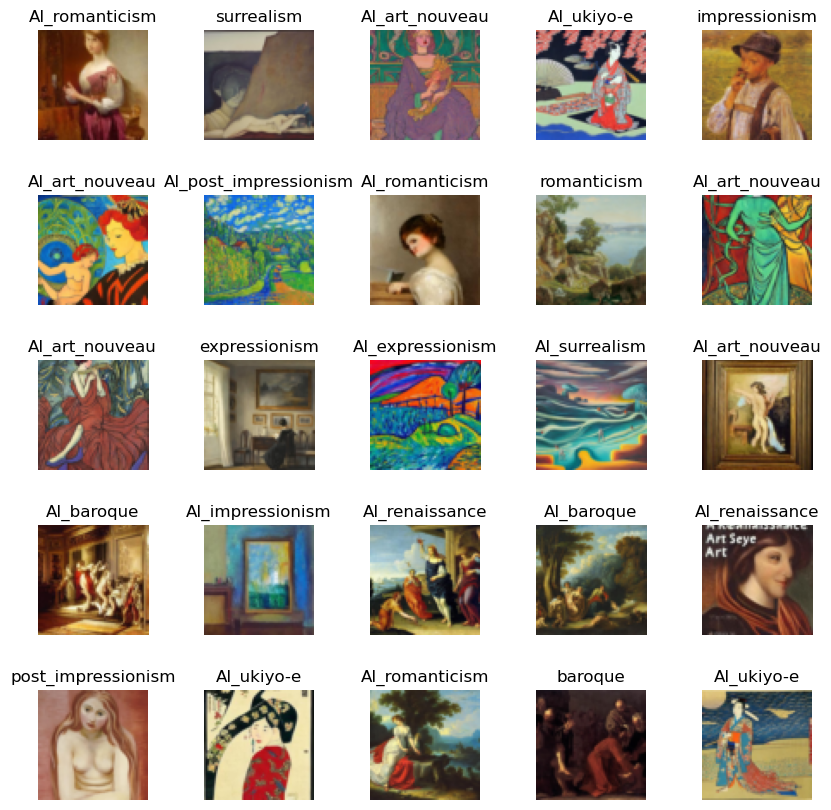

In [5]:
images, labels = next(data_iter)
next(data_iter)
PlotImages(0,batch_size,5,5,images,labels,label_names,color=True)

In [6]:
# Define a function to extract features using VGG16
def extract_features(data_dir, img_size, batch_size=512, device='cuda:3' if torch.cuda.is_available() else 'cpu'):
    """
    Extract features from images using the convolutional layers of the VGG16 network.
    
    Args:
        data_dir (str): Directory containing the image dataset. Each class should have its own subfolder.
        img_size (tuple): The resolution (width, height) of the images to resize.
        batch_size (int): Number of images to process in one batch.
        device (str): The device to run the model on, 'cuda' or 'cpu'.
        
    Returns:
        features (numpy.ndarray): Extracted features from the images.
        labels (list): Corresponding class labels for each extracted feature.
    """

    # Load the pre-trained VGG16 model
    vgg16 = models.vgg16(weights='VGG16_Weights.DEFAULT')

    # Only use the convolutional layers (remove the fully connected layers)
    # VGG16 features have conv layers + pooling
    vgg16_features = nn.Sequential(*list(vgg16.features.children())).to(device)

    # Disable gradient calculations since we're only using the model for feature extraction
    for param in vgg16_features.parameters():
        param.requires_grad = False

    # Define the image transformation pipeline
    transform = transforms.Compose([
        transforms.Resize(img_size),      # Resize to the specified resolution
        transforms.ToTensor(),            # Convert images to PyTorch tensors
        transforms.Normalize(             # Normalize images to match VGG16 input requirements
            mean=[0.485, 0.456, 0.406],   # These are the mean values for VGG16's training data (ImageNet)
            std=[0.229, 0.224, 0.225]     # These are the standard deviations for ImageNet
        )
    ])

    # Load the dataset, where each class is in its own subfolder
    dataset = ImageFolder(root=data_dir, transform=transform)

    # Create a DataLoader to handle batch processing of images
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    # Lists to store extracted features and corresponding labels
    all_features = []
    all_labels = []

    # Iterate through the dataset in batches
    for images, labels in dataloader:
        images = images.to(device)  # Send images to the specified device (GPU or CPU)

        # Pass images through the VGG16 convolutional layers
        features = vgg16_features(images)

        # Flatten the features (we take the output from the last conv layer)
        features = features.view(features.size(0), -1)

        # Move the features back to CPU (to prepare for saving)
        features = features.cpu().detach().numpy()

        # Append the extracted features and labels
        all_features.append(features)
        all_labels.append(labels.numpy())  # Labels are already on CPU, so just append them

    # Concatenate all features and labels from the batches into single arrays
    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels

In [ ]:
# Extract features and labels
features, labels = extract_features(data_dir, img_size)

# Save the extracted features and labels as a .npz file
save_file = f"Features/{str(px)}_{data_file}_features.npz"
np.savez(save_file, features=features, labels=labels)

print(f"Features and labels extracted and saved to '{save_file}'.")

In [ ]:
print(features.shape)
print(labels.shape)